# CQA Random Forest Prediction with Liquidity-adjusted Portfolio Weights

In this code file, we have build upon the simple random forest classification scheme, by including a liquidity-adjusted portfolio weights scheme.

Essentially, rather than longing all the stocks that model predict as generating positive return, we only take long positions in the stocks that are in the top 25th Percentile rank in terms of stock liquidity.

Note: In this code scheme, liquidity refers to market cap* total trading volume.

delayed return  
84_Q data

In [2]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

### import alpha library

In [3]:
# read data
data_matrix1 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_20_Q.csv")
data_matrix2 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_21_to_40_Q.csv")
data_matrix3 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_41_to_60_Q.csv")
data_matrix4 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_61_to_84_Q.csv")

In [4]:
data_matrix = pd.concat([data_matrix1,data_matrix2,data_matrix3,data_matrix4],ignore_index=True)

### monthly return

In [5]:
monthly_returns = data_matrix[['asOfDate','tic','Return']]

In [6]:
tics = data_matrix['tic']
dates = data_matrix['asOfDate']
dates = dates.apply(lambda x: x[:7])

In [7]:
dates

0         2010-09
1         2010-09
2         2010-09
3         2010-09
4         2010-09
5         2010-09
6         2010-09
7         2010-09
8         2010-09
9         2010-09
10        2010-09
11        2010-09
12        2010-09
13        2010-09
14        2010-09
15        2010-09
16        2010-09
17        2010-09
18        2010-09
19        2010-09
20        2010-09
21        2010-09
22        2010-09
23        2010-09
24        2010-09
25        2010-09
26        2010-09
27        2010-09
28        2010-09
29        2010-09
           ...   
251970    2017-08
251971    2017-08
251972    2017-08
251973    2017-08
251974    2017-08
251975    2017-08
251976    2017-08
251977    2017-08
251978    2017-08
251979    2017-08
251980    2017-08
251981    2017-08
251982    2017-08
251983    2017-08
251984    2017-08
251985    2017-08
251986    2017-08
251987    2017-08
251988    2017-08
251989    2017-08
251990    2017-08
251991    2017-08
251992    2017-08
251993    2017-08
251994    

## 1. Data preprocess

separate dates, returns (label) and alphas (data) from data matrix

In [8]:
mask = [i for i in list(range(14,488))+list(range(498,499))]
alpha_library = data_matrix.iloc[:,mask]
alpha_library.head()

,ALPHA_77,ALPHA_267,ALPHA_505,ALPHA_572,ALPHA_25,SPPIVY,ALPHA_129,ALPHA_264,OPMBD,OPMBD1,...,DOQ,DOY,IBADJQ,IBQ,IBADJY,IBY,CSH12Q,CSHPRQ,CSHPRY,LIQUIDITY.1
0,-0.129319,0.053984,0.306399,0.346287,-0.066755,14.0,0.000000,2.028620,0.287070,0.287070,...,0.0,0.0,3253.0,3253.0,9705.0,9705.0,905.3295,912.197,907.762,5363.250030
1,-0.273262,-0.003845,0.233960,-0.231986,-0.166918,-771.0,1.056310,-1.211370,0.295827,0.295827,...,0.0,0.0,2741.0,3123.0,5331.0,6305.0,9102.1828,9956.773,9570.166,1891.193156
2,-0.323743,0.103459,0.204940,0.259946,1.604720,-1061.0,1.980420,-0.135714,0.300105,0.300105,...,-3.0,208.0,2674.0,2700.0,6860.0,6917.0,23195.6250,28849.400,28646.900,1551.418943
3,-0.055053,0.058377,0.426733,2.559450,-0.082981,NaN,0.536183,0.816442,0.414490,0.414490,...,0.0,0.0,4518.0,4518.0,18760.0,18760.0,8813.0000,8712.000,8813.000,1474.759158
4,-0.127456,0.058582,0.412080,1.127290,-0.024606,0.0,0.000000,1.159110,0.396041,0.396041,...,0.0,0.0,1840.0,1840.0,3795.0,3795.0,317.4950,318.350,318.123,1353.579613


### Function1: delete columns with too many nan 
input:    
data -- dataframe;   
ratio -- threshold of (number of NA's)/(data size);
      
output:    
data -- dataframe which the ratio less than threshold ratio

In [9]:
# delete columns with too many nan
def delete_columns_with_too_many_nan(data, ratio):
    return data.loc[:,data.isnull().mean()<(ratio)]

After delete all the alpha with >0.1 NA's, the alpha library contains 464 alphas.

In [10]:
alpha_library = delete_columns_with_too_many_nan(alpha_library, 0.1)
alpha_library.shape

(252000, 475)

### Function2: replace NA's with mean in the column

In [11]:
# replace nan with mean
def replace_nan_with_mean(data):
    col_names = list(data)
    col_mean = np.nanmean(data, axis=0)
    values = {}
    for i in range(len(col_names)):
        values[col_names[i]] = col_mean[i]
    return data.fillna(values)


In [12]:
alpha_library = replace_nan_with_mean(alpha_library)

### Function3: data mask
input:   
start_year,start_quarter,train_time,delay

output:   
training data

In [13]:
def monthly_delay(start_year,start_month,delay):
    if start_month<10:
        start_time = str(start_year)+'-0'+str(start_month)
    else:
        start_time = str(start_year)+'-'+str(start_month)    
    
    response_month = start_month+delay
    if response_month>12:
        response_year = start_year+1
        response_month = response_month-12
    else:
        response_year = start_year
        
    if response_month<10:
        response_time = str(response_year)+'-0'+str(response_month)
    else:
        response_time = str(response_year)+'-'+str(response_month)
        
    return start_time,response_time


#convert from the original start year and month to one month later on for testing sample
def convert_to_test(start_year,start_month,delay):
    #normal addition process
    #if start_month <12:
    if start_month <9:
        start_yr = start_year
        #start_m = start_month +1
        start_m = start_month +delay
        
    #adding another year
    else: 
        start_yr = start_year + 1 
        #start_m = 1 
        start_m = start_month + delay - 12
    
    return start_yr, start_m 

In [14]:
def retrive_train(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay):
    start_time,response_time = monthly_delay(start_year,start_month,delay)
    
    train_mask = dates == start_time
    train_alpha  = alpha_library[train_mask]
    train_tic = list(tics[train_mask])
    
    response_mask = dates == response_time
    response_return = monthly_returns['Return'][response_mask]
    response_tic = monthly_returns['tic'][response_mask]

    # create a tic-return dictionary
    response_dict = dict([(i,j) for i,j in zip(response_tic,response_return)])

    # create returns
    train_Y = np.zeros([train_alpha.shape[0],1])
    for i in range(len(train_tic)):
        if train_tic[i] in response_dict:
            train_Y[i] = response_dict[train_tic[i]]
        else:
            train_Y[i] = None
            
    train_Y = pd.DataFrame(train_Y)
    
    # filter nan in returns
    train_alpha['label'] = train_Y.values
    train_Y = train_alpha.loc[~train_alpha['label'].isnull(),'label']
    train_X = train_alpha.loc[~train_alpha['label'].isnull(),].drop(columns=['label','LIQUIDITY.1'])
    liquidity_vec = train_alpha.loc[~train_alpha['label'].isnull(),'LIQUIDITY.1']

    return train_X,train_Y,liquidity_vec

In [15]:
def retrive_test(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay):
    start_time,response_time = monthly_delay(start_year,start_month,delay)
    test_mask = dates == start_time
    test_X_1  = alpha_library[test_mask]
    test_X = test_X_1.drop(columns=['LIQUIDITY.1'])
    test_tic = list(tics[test_mask])
    liquidity_test = test_X_1.loc[:,'LIQUIDITY.1']

    return test_X,test_tic,response_time,liquidity_test

## 2. Random Forest Prediction with Liqudity-adjusted Weights

In [16]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import warnings
warnings.filterwarnings('ignore')

In [17]:
#import data files
import os
returns_folder = "C:\\Users\\tony\\Desktop\\CQA\\data\\dr\\"
files_list = os.listdir(returns_folder)
files_list = sorted(files_list)

There are two different strategy for the portfolio management.   
(1) invest one (or negetive one) dollar every day for each company  
(2) invest one(or negetive one) dollar in the beginning of every month for each company  

The following function is based on assumption (2).

In [18]:
def portfolio_monthly_returns(date,files_list,returns_folder,returns,x):
    daily_returns = pd.DataFrame([], columns=('date','portfolio_value','portfolio_return'))
    i = 0
    for temp_file in files_list:
        if date in temp_file:
            return_temp = pd.read_csv(returns_folder+temp_file)
            return_temp = return_temp.dropna()
        
            for j in range(return_temp.shape[0]):
                if return_temp.iloc[j,0] in returns:
                    comp_tic = return_temp.iloc[j,0]
                    returns[comp_tic] = returns[comp_tic]*(1+return_temp.iloc[j,1])
            ###
            daily_returns.loc[i] = [pd.Timestamp(temp_file[:10]),x+sum(returns.values()),None]
            ###
            #daily_returns.loc[i] = [pd.Timestamp(temp_file[:10]),1+sum(returns.values()),None]
            if i>0:
                daily_returns['portfolio_return'][i] = (daily_returns['portfolio_value'][i]-daily_returns['portfolio_value'][i-1])/daily_returns['portfolio_value'][i-1]
                #daily_returns['portfolio_return'][i] = 
                
            else:
                daily_returns['portfolio_return'][i] = (daily_returns['portfolio_value'][i]-x)/x
            i = i+1
    month_return = (daily_returns['portfolio_value'][i-1]-x)/x

    return daily_returns,month_return 

<span class="burk">Function that adjust weights based on liquidity (i.e scaling_classify), and function that rebalance weights to ensure dollar-neutrality of the new portfolio</span>

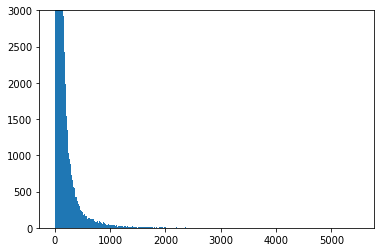

In [19]:
#get liquidity vector, that is defined as the product of market capitalization and trading volume.
liquidity_v = data_matrix['LIQUIDITY.1']
#print(liquidity_v)

#import packages
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean

#descriptive statistics of the liquidity vector
liquidity_v.describe()
hist = np.histogram(liquidity_v)
hist

import matplotlib.pyplot as plt
plt.hist(x=liquidity_v,range=[0, 5500],bins = 300)
axes = plt.gca()
axes.set_ylim([0,3000])


#function that assign portfolio weight-adjustment based on corresponding liqudity scale of the underlying stocks
def scaling_classify(scaling_factor, liquidity_vector, threshold_vector):
    #choose scaling based on quantiles and assign threshold_vector values
    s1 = np.quantile(liquidity_vector, 0.25)
    s2 = np.quantile(liquidity_vector, 0.5)
    s3 = np.quantile(liquidity_vector, 0.75)
    for i in range(len(scaling_factor)):
        #case 1 (below 25th percentile)
        if liquidity_vector[i] <s1:
            scaling_factor[i] = threshold_vector[0]
        #case 2 (between 25th percentile and 50th percentile)
        elif liquidity_vector[i] >=s1 and liquidity_vector[i] <s2:
            scaling_factor[i] = threshold_vector[1]
        #case 3 (between 50th percentile and 75th percentile)
        elif liquidity_vector[i] >=s2 and liquidity_vector[i]< s3:
            scaling_factor[i] = threshold_vector[2]
        #case 4 (above 75th percentile)
        elif liquidity_vector[i] >=s3:
            scaling_factor[i] = threshold_vector[3]
        else:
            return()
    return(scaling_factor)
    
#function that ensure the dollar-neutrality of the newly adjusted portfolio
def weight_balance(portfolio_pre_weights,scaling_factor,x):
    total_sum = abs(np.dot(portfolio_pre_weights,scaling_factor))
    if total_sum == x/2:
        return(portfolio_pre_weights,scaling_factor)
    elif total_sum < x/2:
        rescaling = (x/2)/total_sum
        portfolio_pre_weights = [rescaling*i for i in portfolio_pre_weights]
        return(portfolio_pre_weights,scaling_factor)
    elif total_sum > x/2:
        rescaling = (x/2)/total_sum
        portfolio_pre_weights = [rescaling*i for i in portfolio_pre_weights]
        return(portfolio_pre_weights,scaling_factor)
    else:
        return()
        
     

portfolio_return for 2011-05 is  0.0028271718017192082
1.0028271718017192
portfolio_return for 2011-06 is  0.008152233130380621
1.011002452695727
portfolio_return for 2011-07 is  -0.006961676950911088
1.0039641802234807
portfolio_return for 2011-08 is  0.017971959709944016
1.022007384020684
portfolio_return for 2011-09 is  0.01955958325482277
1.0419974225354802
portfolio_return for 2011-10 is  0.018157912576832365
1.0609179206391641
portfolio_return for 2011-11 is  0.003353588781212123
1.0644758030756065
portfolio_return for 2011-12 is  0.020475615259282254
1.0862716000721981
portfolio_return for 2012-01 is  0.010371573130033618
1.0975379454114256
portfolio_return for 2012-02 is  -0.0039982939773127325
1.0931496660544149
portfolio_return for 2012-03 is  0.0028390292297790524
1.0962531499088666
portfolio_return for 2012-04 is  0.0008889476250585767
1.097227661542941
portfolio_return for 2012-05 is  -0.00930872005340925
1.087013876406781
portfolio_return for 2012-06 is  -0.00050554564176

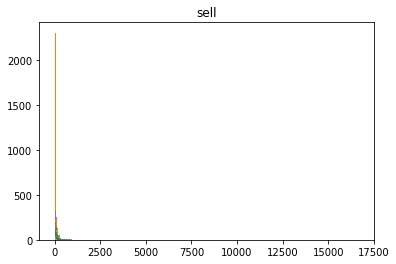

In [21]:
#Iterative algorithm that performs the backtesting 
from sklearn.ensemble import RandomForestClassifier
from matplotlib.backends.backend_pdf import PdfPages

#paramters to be assigned
delay = 4 # delay
m = 1500 # number_of_stocks
portfolio_returns = pd.DataFrame([], columns=('date','portfolio_return'))
portfolio_daily_returns = pd.DataFrame([], columns=('date','portfolio_value','portfolio_return'))
i = 0
set_dates = list(sorted(set(dates)))
x = 1

#for loop of the iterative algorithm
for k in range(len(set_dates)-delay-delay):
    date = set_dates[i]
    start_year = int(date[:4])
    start_month = int(date[5:7])
    
    train_X,train_Y,liquidity_train = retrive_train(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay)
    
    ##############################################
    #roll over the relationship one period ahead
    #start_y, start_m = convert_to_test(start_year,start_month)
    start_y, start_m = convert_to_test(start_year,start_month,delay)
    test_X,test_tic,response_time,liquidity_test = retrive_test(alpha_library,monthly_returns,dates,tics,start_y,start_m,delay)
    ################################################
    
    #convert to binary return of Buy/sell
    train_Y = np.where(train_Y > np.repeat(0, len(train_Y)), "Buy","Sell")

    #create random forest object
    #rf = RandomForestRegressor()
    rf = RandomForestClassifier()
    # Train the model on training data
    rf.fit(train_X, train_Y);
    #make predictions using testing set 
    pred_Y_rf = rf.predict(test_X)
    
    
    #long the stocks that classify as Buy, and short the stocks that classify as sell
    companies = test_tic
    pred = dict(zip(companies, pred_Y_rf))

    #################################################################################
    #equal weighted dollar neutral portfolio#
    #number of longing stocks to account for dollar-neutral
    ls = np.where(pred_Y_rf == 'Buy', 1,0)
    nl = sum(ls)
    
     #number of shorting stocks to account for dollar-neutral
    ss = np.where(pred_Y_rf == 'Sell',1,0)
    ns = sum(ss)
    
    ###################################################################################
    
    #create vector(for both long and short positions) for liquidity factor
    #and then try to see distribution of the liquidity factor for each portfolio
    lf_b = {}
    lf_s = {}
    lf_all = {}
    combined_vector = list(zip(pred_Y_rf,liquidity_test))
    lid = dict(zip(companies,combined_vector ))
    for j in companies:
        if lid[j][0] == 'Buy':
            lf_b[j] = lid[j][1] 
        else: 
            lf_s[j] = lid[j][1]
        lf_all[j]= lid[j][1]
     
    #plot different histograms for both long and short side portfolio's liquidity
    L_b = list(lf_b.values())
    L_s = list(lf_s.values())
    plt.hist(x= L_b,bins = 300)
    plt.title('buy')
    plt.hist(x= L_s,bins = 300)
    plt.title('sell')

    ###########################
    #liquidity_weighted portfolio optimization#
    data_b = pd.DataFrame.from_dict(lf_b,orient = 'index')
    data_s = pd.DataFrame.from_dict(lf_s,orient = 'index')
    
    weight_b = data_b.iloc[:,0].values
    weight_s = data_s.iloc[:,0].values
    
    #initialize the portfolio weights
    # 20 
    portfolio_weights_b = np.tile(x/nl/1000,nl)
    # 20 
    portfolio_weights_s = np.tile(-x/ns/1000,ns)
    scaling_factor_b = np.tile(0,nl) 
    scaling_factor_s = np.tile(0,ns)
    
    #change scaling of the scaling factor
    ############################
    scaling_factor_new_b = scaling_classify(scaling_factor_b,weight_b,[0,0,0,500])
    scaling_factor_new_s = scaling_classify(scaling_factor_s,weight_s,[0,0,0,500])
    
    #rebalance the portfolio weights to make it dollar neutral
    portfolio_weights_b,scaling_factor_new_b= weight_balance(portfolio_weights_b,scaling_factor_new_b,x)
    portfolio_weights_s,scaling_factor_new_s= weight_balance(portfolio_weights_s,scaling_factor_new_s,x)
    
    portfolio_weights_b = np.multiply(portfolio_weights_b,scaling_factor_new_b)
    portfolio_weights_s = np.multiply(portfolio_weights_s,scaling_factor_new_s)
    
    #find the corresponding companies from index, IN THE SAME ORDER
    #then forms a new dictionary of returns
    return_companies = list(data_b.index) + list(data_s.index)
    return_weights = portfolio_weights_b.tolist() + portfolio_weights_s.tolist()
    returns = {}
    for zz in range(len(return_companies)):
        returns[return_companies[zz]]= return_weights[zz]

        
    #calculate the portfolio monthly return and iterate
    daily_returns,portfolio_return = portfolio_monthly_returns(response_time,files_list,returns_folder,returns,x)
    print('portfolio_return for',response_time, 'is ',portfolio_return)
    
    portfolio_daily_returns = pd.concat([portfolio_daily_returns, daily_returns], ignore_index=True)
    portfolio_returns.loc[i] = [pd.Timestamp(response_time),portfolio_return]
    i = i+1
    x = daily_returns.iloc[-1,1]
    print(x)

    

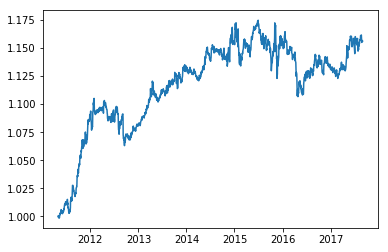

In [22]:
aggregate = [1]
for i in portfolio_daily_returns['portfolio_return']:
    aggregate.append(aggregate[-1]*(i+1))
aggregate = aggregate[1:]
#print(aggregate)
plt.plot(portfolio_daily_returns['date'],aggregate)

In [23]:
portfolio_daily_returns = portfolio_daily_returns.set_index(portfolio_daily_returns['date'])

## 3. output

In [24]:
def mean_return(returns):
    return 252*np.mean(returns)*100
    
def vol(returns):
    return np.sqrt(252)*np.std(returns)*100

def sharpe_ratio(returns):
    return np.sqrt(252)*np.mean(returns)/np.std(returns)

def Sortino(returns):
    return np.sqrt(252)*np.mean(returns)/np.std(returns[returns<0])

def draw_down(returns):
    # We are going to use a trailing 252 trading day window
    window = 252
    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    #Roll_Max = pd.rolling_max(returns, window, min_periods=1)
    
    Roll_Max = returns.rolling(window,min_periods = 1).max()
    Daily_Drawdown = returns/Roll_Max - 1.0

    # Then we calculate the minimum daily drawdown, which is equivalent to maximum drawdown 
    # Again, use min_periods=1 if you want to allow the expanding window
    #Max_Daily_Drawdown = pd.rolling_min(Daily_Drawdown, window, min_periods=1)
    Max_Daily_Drawdown = Daily_Drawdown.rolling(window,min_periods = 1).min()
    return Max_Daily_Drawdown
    

In [25]:
for year in range(2011,2017):
    returns = portfolio_daily_returns[str(year)+'-01-01':str(year+1)+'-01-01']['portfolio_return']
    #print(len(returns))
    print(draw_down(returns)[-1])
    print('year %4d, mean return = %.4f, Volatility = %.4f, sharpe ratio = %.4f, Max_Drawdown Rate = %.4f, Sortino ratio = %.4f' % \
          (year,mean_return(returns),vol(returns),sharpe_ratio(returns),draw_down(returns)[-1],Sortino(returns)))

year 2011, mean return = 12.1871, Volatility = 3.4702, sharpe ratio = 3.5120, Sortino ratio = 6.0151
year 2012, mean return = -0.3674, Volatility = 3.5715, sharpe ratio = -0.1029, Sortino ratio = -0.1400
year 2013, mean return = 4.7482, Volatility = 2.8376, sharpe ratio = 1.6733, Sortino ratio = 2.1109
year 2014, mean return = 1.9404, Volatility = 3.2107, sharpe ratio = 0.6044, Sortino ratio = 0.9021
year 2015, mean return = 0.0801, Volatility = 5.1606, sharpe ratio = 0.0155, Sortino ratio = 0.0224
year 2016, mean return = -2.0112, Volatility = 3.4513, sharpe ratio = -0.5827, Sortino ratio = -0.9582


total portfolio return

In [26]:
aggregate[-1]-1

0.15593053290221381